In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/FinalProject/task1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/FinalProject/task1


In [ ]:

import os
import cv2 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches
from math import sqrt
import cv2
import re
import json
import random
import torchvision
from tqdm import tqdm 
torch.manual_seed(1234)
np.random.seed(1234)
import warnings
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset
from sklearn import model_selection
WIDTH=HEIGHT=300
EPOCH_N=100
CLASS_N=2
device='cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings("ignore")

In [ ]:

def get_data(data_train_path='../data/task1_train'):
	new_data=[]
	data={}
	for file in os.listdir(data_train_path):
		if re.match('^((?!\)).)*$',file):
			new_data.append(re.sub('.txt|.jpg$','',file))
	codeSet=set(new_data)

	for code in codeSet:
		data[os.path.join(data_train_path,code+'.jpg')]=os.path.join(data_train_path,code+'.txt')

	return data



def save_jsonFile(data):
	with open('../data/data_task1_train.json','w') as f:
		json.dump(data,f,indent=4)

def read_json_file(path='../data/data_task1_train.json'):
	with open(path,'r') as f:
		data=json.load(f)
		return data


def show_retangle_from_file(k,v):
  img=cv2.imread(k)
  with open(v,'r') as f:
	  for line in f:
		  bx=line.split(',')
		  x_min=int(bx[0])
		  y_min=int(bx[1])
		  x_max=int(bx[4])
		  y_max=int(bx[5])
		  cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255,0), 2)
  plt.figure(figsize=(15, 15))
  plt.imshow(img)
  plt.show()


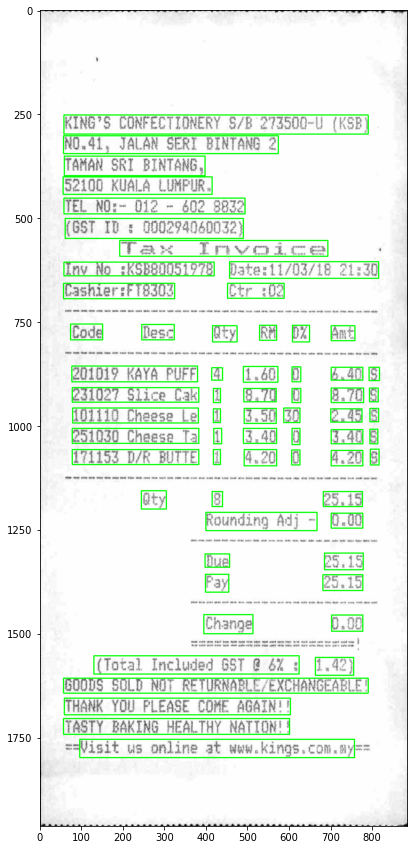

In [ ]:
data=read_json_file()
item=iter(data.items())
item=next(item)
show_retangle_from_file(item[0],item[1])

In [ ]:
def get_offsets(v):
  bbxs=[]
  
  with open(v,'r') as f:
    for line in f:
      bx=line.split(',')
      x_min=int(bx[0])
      y_min=int(bx[1])
      x_max=int(bx[4])
      y_max=int(bx[5])
      bbxs.append([x_min,y_min,x_max,y_max])
  return bbxs

def my_draw(img,bbxs):
  for bbx in bbxs:
    cv2.rectangle(img, (bbx[0], bbx[1]), (bbx[2], bbx[3]), (0, 255,0), 2)
  plt.figure(figsize=(15, 15))
  plt.imshow(img)
  plt.show()


In [ ]:


class XrayImgDataset(Dataset):

    def __init__(self,img_paths,targets_paths):
        self.img_paths=img_paths
        self.targets_paths=targets_paths
        self.transforms=transforms.ToTensor()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):

        img=cv2.imread(self.img_paths[idx]) # BGR
        height,width,channels=img.shape
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB
        img=cv2.resize(img,(HEIGHT,WIDTH))
        img=img.astype(float)
        img=self.transforms(img)
        img=img/255

        tar_path=self.targets_paths[idx]
        with open(tar_path,'r') as f:
            bbxs=[]
          
            for line in f:
                bx=line.split(',')
                x_min=int(bx[0])
                y_min=int(bx[1])
                x_max=int(bx[4])
                y_max=int(bx[5])
                bbxs.append([x_min/width*WIDTH,y_min/height*HEIGHT,x_max/width*WIDTH,y_max/height*HEIGHT])
               
        bbxs=torch.FloatTensor(bbxs)
        targets={}
        targets['boxes']=bbxs
        targets['labels']=torch.ones(bbxs.shape[0]).long()
          
        return img,targets



In [ ]:
data=read_json_file()
img_paths = list(data.keys())
targets_paths = list(data.values())
## split
X_train, X_val, y_train, y_val = model_selection.train_test_split(img_paths, targets_paths, test_size=0.1, random_state=1)

train_dataset = XrayImgDataset(X_train,y_train)
val_dataset = XrayImgDataset(X_val,y_val)
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True,collate_fn=lambda x: list(zip(*x)),)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False,collate_fn=lambda x: list(zip(*x)),)


In [ ]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features=model.roi_heads.box_predictor.cls_score.in_features
print(in_features)
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,CLASS_N)
model=model.to(device)
params=[p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)
#print(list(model.children())) 

1024


In [ ]:
best_point=9999
for epoch in range(EPOCH_N):
  print("Training...")
  train_loss=0
  val_loss=0
  for imgs,targets in tqdm(train_dataloader):
    model.train()
    model=model.double()
    optimizer.zero_grad()
    imgs=list(img.to(device) for img in imgs)
    targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
    loss_dict=model(imgs,targets)
    losses=sum(loss for loss in loss_dict.values())   	
    losses.backward()
    
    optimizer.step()

    train_loss+=losses.item()
    print(losses.item())

  for imgs,targets in tqdm(val_dataloader):
    model.eval()
    imgs=list(img.to(device) for img in imgs)
    targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
    loss_dict_val=model(imgs,targets)
    losses_val=sum(loss for loss in loss_dict.values())
    val_loss+=losses_val.item()
    if losses_val.item()<best_point:
      best_point=losses_val.item()
      torch.save(model.state_dict(), "./best_val_faster.pth")

		#print(losses.item())

  print("------------------------->", train_loss,val_loss)

In [ ]:
model.load_state_dict(torch.load( "./best_val_faster.pth"))
item=iter(val_dataloader)
images,targets=item.next()
def view(images,targets,k,std=1,mean=0):
  figure=plt.figure(figsize=(30,30))
  images=list(images)
  targets=list(targets)
  for i in range(k):
    out=torchvision.utils.make_grid(images[i])
    inp=out.cpu().numpy().transpose((1,2,0))
    inp=np.array(std)*inp+np.array(mean)
    inp=np.clip(inp,0,1)  
    ax = figure.add_subplot(2,2, i + 1)
    ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
    l=targets[i]['boxes'].cpu().numpy()
    l[:,2]=l[:,2]-l[:,0]
    l[:,3]=l[:,3]-l[:,1]
    for j in range(len(l)):
      ax.add_patch(patches.Rectangle((int(l[j][0]),int(l[j][1])),int(l[j][2]),int(l[j][3]),linewidth=2,edgecolor='b',facecolor='none'))

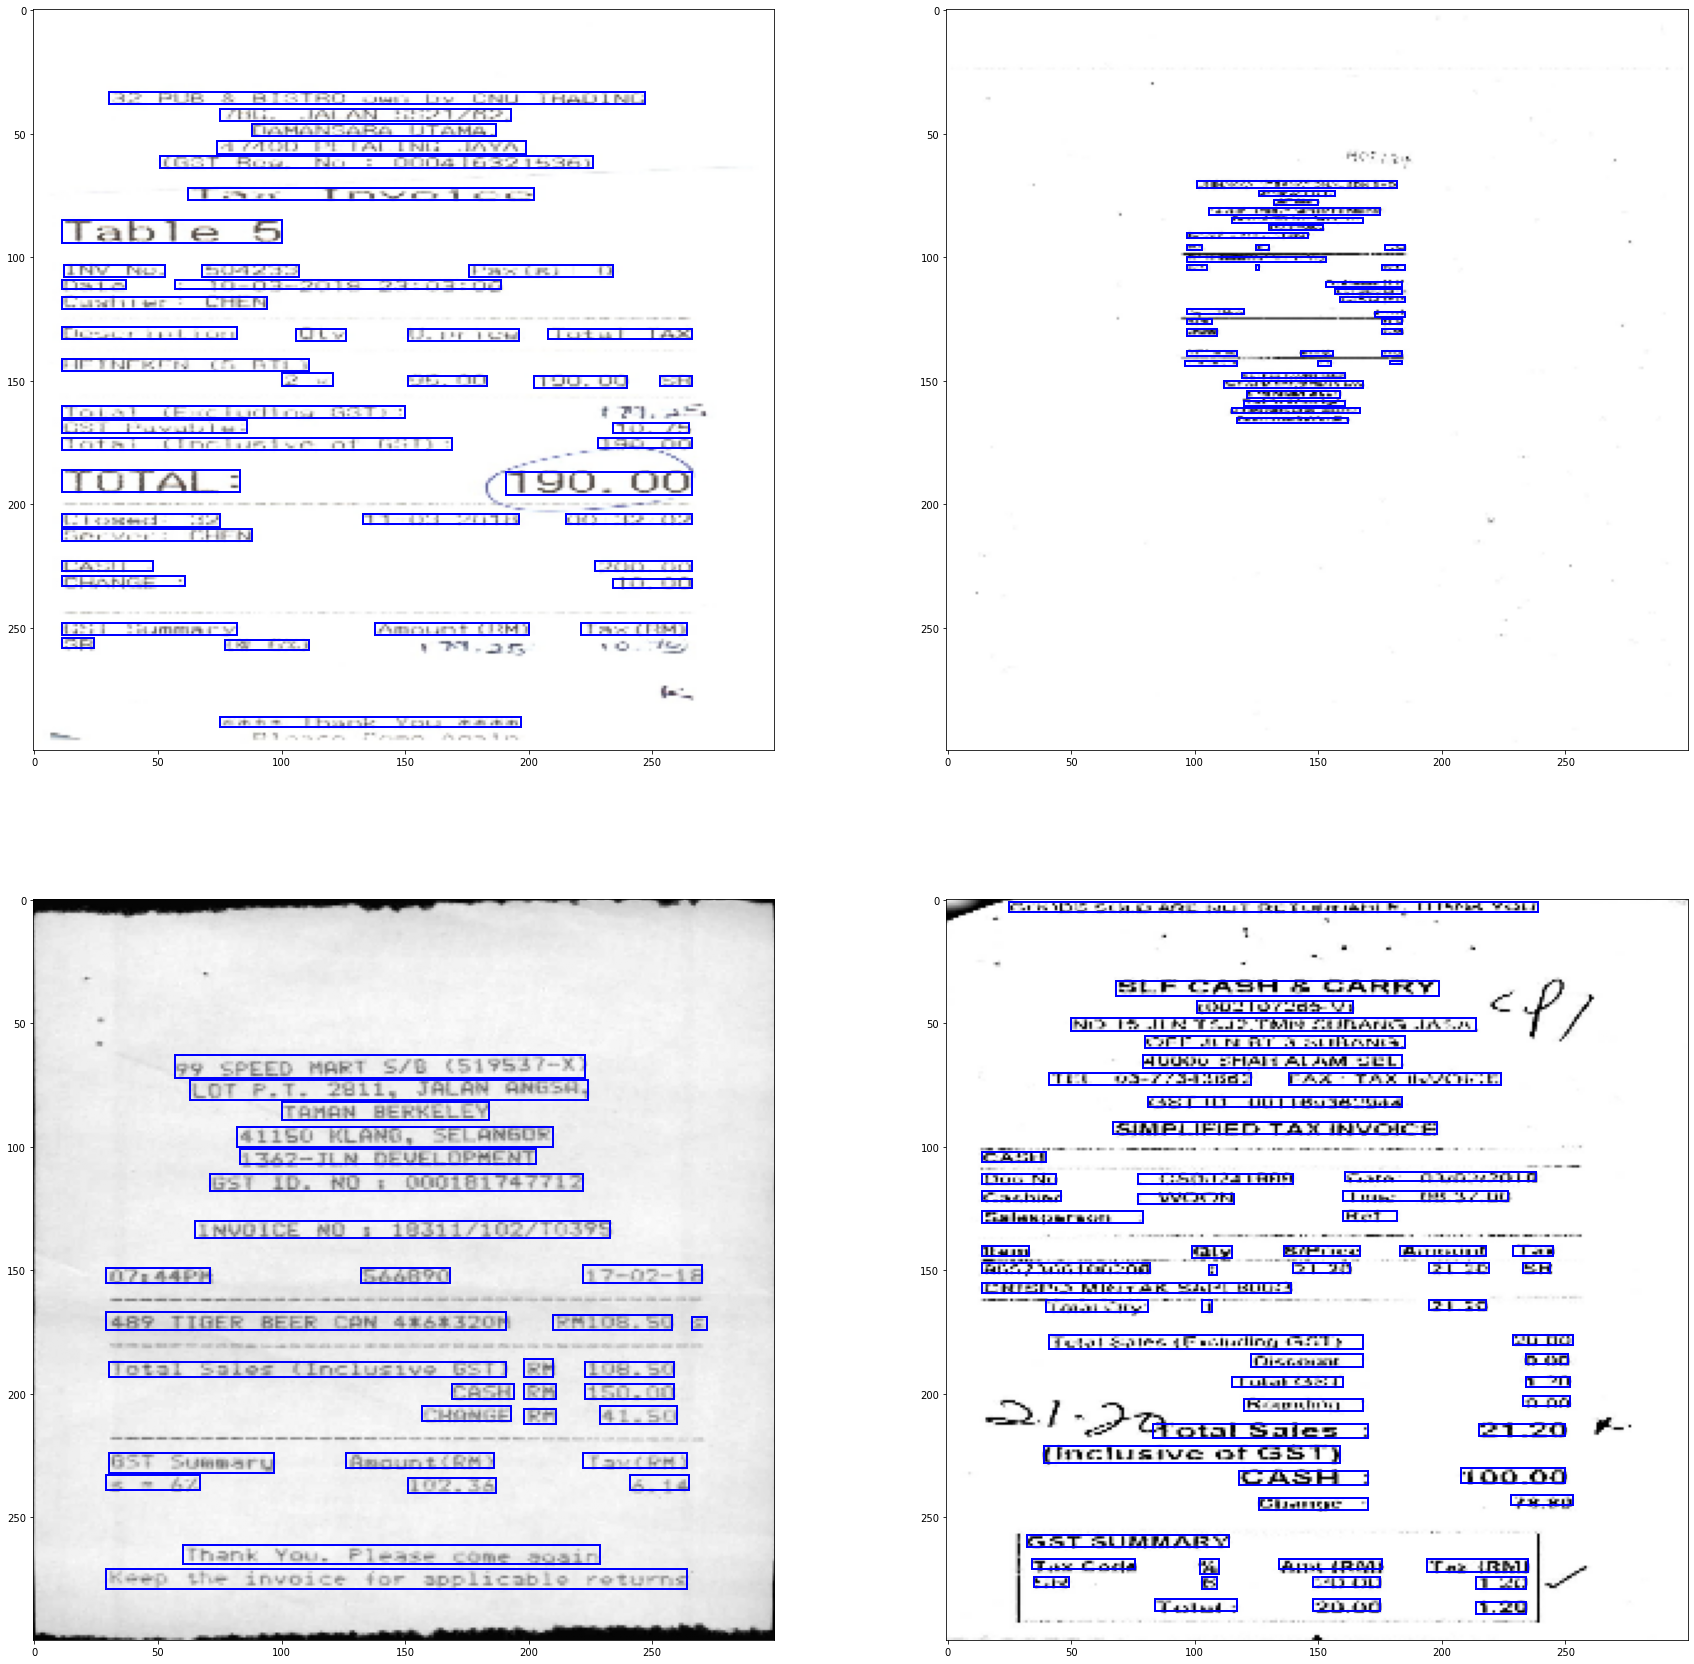

In [ ]:
view(images,targets,4) # truth


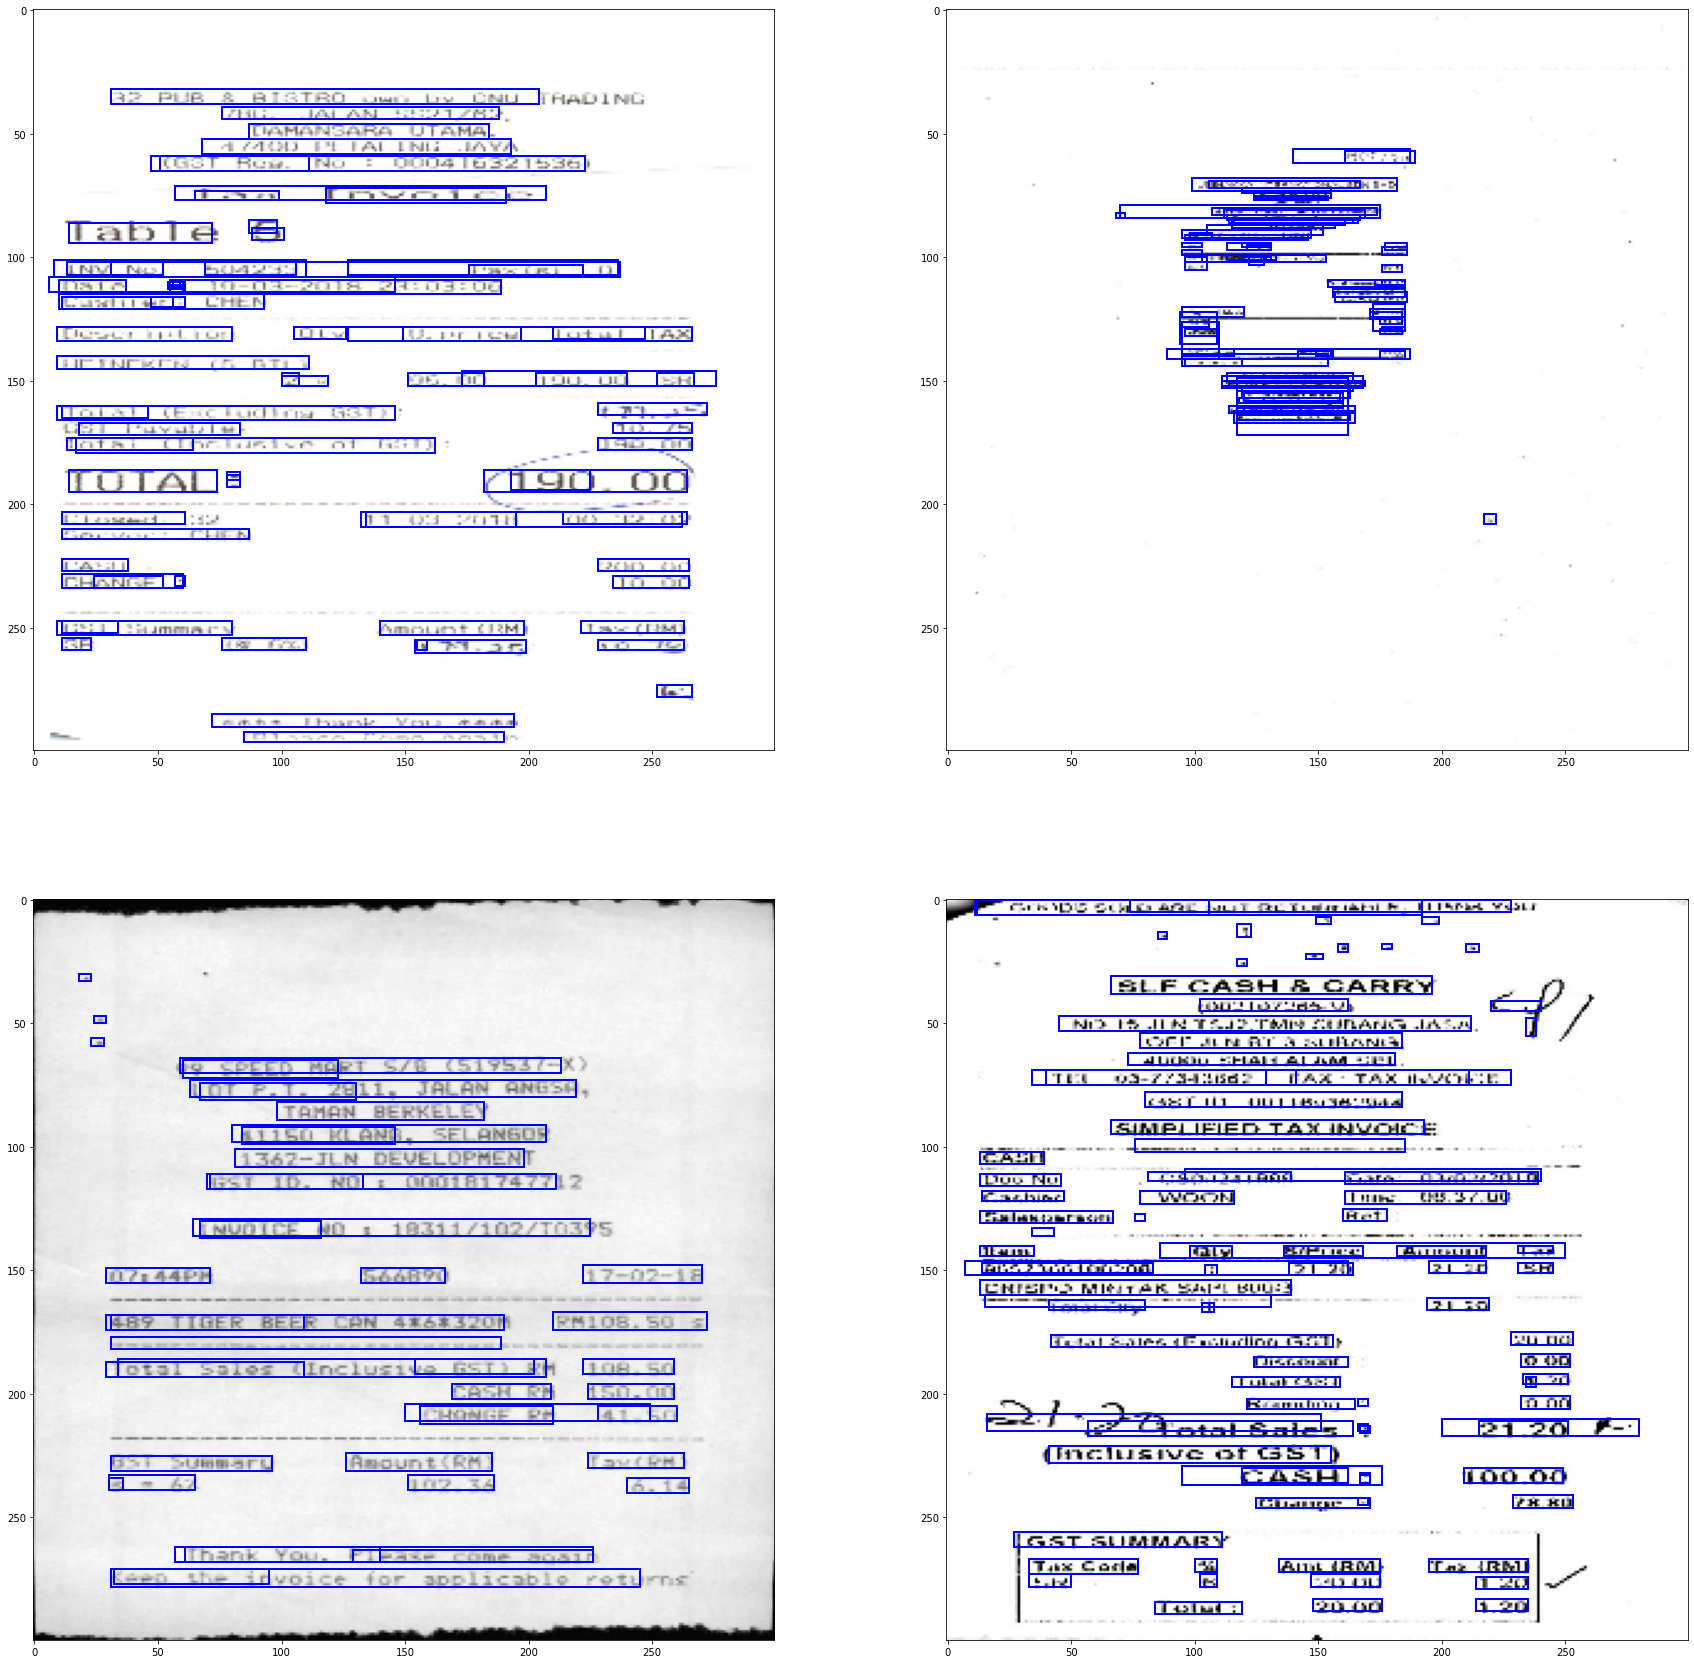

In [ ]:

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
model=model.double()
output=model(images)
# predict :))
with torch.no_grad():
    view(images,output,4)